In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/downsampled_df_random.csv')
data.head()

,userId,wine,rate
0,976ec198-048f-405c-b6e6-b17ee1db1139,Nebbiolo d alba superiore,4
1,4eb7031c-da00-48f4-bc7f-0a1f1eda7cab,Malvasia legno,3
2,13016d41-00bd-411c-83f5-2b95691696b7,Bianco,3
3,13016d41-00bd-411c-83f5-2b95691696b7,Cabernet Franc,3
4,0a23a07a-8556-4ef6-85ee-d996f8ed619e,Talò Primitivo - Merlot,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithMeans (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithMeans.fit(self, trainset_fold)
            train_prediction = KNNWithMeans.test(self, trainset_fold.build_testset())
            prediction = KNNWithMeans.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithMeans.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithMeans SGD

* knn_with_means cosine, user based

In [4]:
knn_with_means = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means.create_reader(data)
predictions = knn_with_means.fit()
#acc
metrics = knn_with_means.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2476
RMSE: 0.8507
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2838
RMSE: 0.9278
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2234
RMSE: 1.0401
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2294
RMSE: 0.9685
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2149
RMSE: 0.9819
###############################################
The Results are: 

Average RMSE on Training Set: 0.2398328974675057
Average RMSE on Test Set: 0.953780236008981
RMSE: 0.9734
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9734156212222466
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9734
MAE:  0.7693
MSE: 0.9475
Precision: 0.69
Recall: 0.76
the acc is 43.70


/tmp/ipykernel_18154/655597585.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_means cosine, item based

In [5]:
knn_with_means2 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means2.create_reader(data)
predictions = knn_with_means2.fit()
#acc
metrics = knn_with_means2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3209
RMSE: 0.8857
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3039
RMSE: 0.9705
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2624
RMSE: 1.0410
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2634
RMSE: 1.0196
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2887
RMSE: 1.0709
###############################################
The Results are: 

Average RMSE on Training Set: 0.28785443132976607
Average RMSE on Test Set: 0.9975447577089767
RMSE: 0.9104
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.910421509084067
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9104
MAE:  0.7659
MSE: 0.8289
Precision: 0.62
Recall: 0.72
the acc is 37.82


/tmp/ipykernel_18154/3877873262.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/3877873262.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared difference, user based

In [6]:
knn_with_means3 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means3.create_reader(data)
predictions = knn_with_means3.fit()
#acc
metrics = knn_with_means3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1825
RMSE: 0.9138
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1937
RMSE: 0.9782
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1883
RMSE: 0.8375
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1854
RMSE: 0.8986
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1966
RMSE: 0.8483
###############################################
The Results are: 

Average RMSE on Training Set: 0.18930153579037
Average RMSE on Test Set: 0.8952883521630401
RMSE: 1.0668
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.066776932616362
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0668
MAE:  0.8494
MSE: 1.1380
Precision: 0.54
Recall: 0.61
the acc is 36.13


/tmp/ipykernel_18154/289524525.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/289524525.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared diference, item based

In [7]:
knn_with_means4 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means4.create_reader(data)
predictions = knn_with_means4.fit()
#acc
metrics = knn_with_means4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2284
RMSE: 0.9016
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2012
RMSE: 0.9537
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2341
RMSE: 0.8948
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2306
RMSE: 0.9804
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2225
RMSE: 0.9192
###############################################
The Results are: 

Average RMSE on Training Set: 0.223363871775809
Average RMSE on Test Set: 0.929944679368156
RMSE: 1.0806
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0806044472801455
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0806
MAE:  0.8460
MSE: 1.1677
Precision: 0.65
Recall: 0.73
the acc is 41.18


/tmp/ipykernel_18154/2026458134.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/2026458134.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, user based

In [8]:
knn_with_means5 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means5.create_reader(data)
predictions = knn_with_means5.fit()
#acc
metrics = knn_with_means5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2350
RMSE: 0.8935
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1623
RMSE: 1.0873
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2373
RMSE: 0.7945
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1393
RMSE: 1.0300
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2292
RMSE: 0.9879
###############################################
The Results are: 

Average RMSE on Training Set: 0.2006096492481836
Average RMSE on Test Set: 0.9586300767544413
RMSE: 0.9904
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9904166793583631
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9904
MAE:  0.8214
MSE: 0.9809
Precision: 0.68
Recall: 0.73
the acc is 36.13


/tmp/ipykernel_18154/2000926961.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/2000926961.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_means6 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means6.create_reader(data)
predictions = knn_with_means6.fit()
#acc
metrics = knn_with_means6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1753
RMSE: 0.9190
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1416
RMSE: 0.9917
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1385
RMSE: 1.0506
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1463
RMSE: 0.9988
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1449
RMSE: 1.0889
###############################################
The Results are: 

Average RMSE on Training Set: 0.14932226662856055
Average RMSE on Test Set: 1.0097738768656943
RMSE: 0.8834
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8833642015386689
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8834
MAE:  0.7300
MSE: 0.7803
Precision: 0.58
Recall: 0.63
the acc is 40.34


/tmp/ipykernel_18154/1753961335.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/1753961335.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_means7 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means7.create_reader(data)
predictions = knn_with_means7.fit()
#acc
metrics = knn_with_means7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1759
RMSE: 1.0374
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1882
RMSE: 0.7819
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0661
RMSE: 0.8654
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1853
RMSE: 0.9143
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0862
RMSE: 1.0054
###############################################
The Results are: 

Average RMSE on Training Set: 0.140358834733507
Average RMSE on Test Set: 0.9208697479386345
RMSE: 1.0634
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0633709951081585
Computing the pearson_baseline similarity matrix..

/tmp/ipykernel_18154/101808052.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/101808052.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_means8 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means8.create_reader(data)
predictions = knn_with_means8.fit()
#acc
metrics = knn_with_means8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1789
RMSE: 0.8827
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1787
RMSE: 0.9704
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1066
RMSE: 0.8715
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1725
RMSE: 0.8763
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1674
RMSE: 1.0242
###############################################
The Results are: 

Average RMSE on Training Set: 0.16082911942303613
Average RMSE on Test Set: 0.9250132216722294
RMSE: 0.9919
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.991897227198215
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18154/1437423512.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/1437423512.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans Alternating Least Squares (ALS)

* KnnWithMeans cosine, user based

In [12]:
knn_with_means9 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means9.create_reader(data)
predictions = knn_with_means9.fit()
#acc
metrics = knn_with_means9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2751
RMSE: 0.9742
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3067
RMSE: 0.8524
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2608
RMSE: 1.0277
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2797
RMSE: 0.8692
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2353
RMSE: 1.0741
###############################################
The Results are: 

Average RMSE on Training Set: 0.27152908750500715
Average RMSE on Test Set: 0.9595042579730446
RMSE: 0.9743
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9743167800312132
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9743
MAE:  0.7996
MSE: 0.9493
Precision: 0.66
Recall: 0.73
the acc is 38.66


/tmp/ipykernel_18154/1812438443.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/1812438443.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans cosine, item based

In [13]:
knn_with_means10 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means10.create_reader(data)
predictions = knn_with_means10.fit()
#acc
metrics = knn_with_means10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2399
RMSE: 1.0377
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2476
RMSE: 0.8985
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2716
RMSE: 0.9487
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2578
RMSE: 0.8594
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2869
RMSE: 0.9415
###############################################
The Results are: 

Average RMSE on Training Set: 0.2607462618950976
Average RMSE on Test Set: 0.9371445061921836
RMSE: 0.9826
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9825866038742266
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9826
MAE:  0.7816
MSE: 0.9655
Precision: 0.59
Recall: 0.67
the acc is 42.02


/tmp/ipykernel_18154/3298270025.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/3298270025.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeansWithMeans mean squared difference, user based

In [14]:
knn_with_means11 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means11.create_reader(data)
predictions = knn_with_means11.fit()
#acc
metrics = knn_with_means11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2214
RMSE: 0.8592
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2365
RMSE: 0.9278
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2165
RMSE: 1.0150
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2056
RMSE: 0.9514
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1935
RMSE: 0.9453
###############################################
The Results are: 

Average RMSE on Training Set: 0.21469116423578746
Average RMSE on Test Set: 0.9397138840131001
RMSE: 1.0311
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0310603685851438
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0311
MAE:  0.8361
MSE: 1.0631
Precision: 0.63
Recall: 0.70
the acc is 36.13


/tmp/ipykernel_18154/4069916643.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/4069916643.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeans mean squared difference, item based

In [15]:
knn_with_means12 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means12.create_reader(data)
predictions = knn_with_means12.fit()
#acc
metrics = knn_with_means12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2753
RMSE: 0.8286
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2066
RMSE: 0.9562
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2442
RMSE: 0.9733
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2702
RMSE: 1.0562
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1898
RMSE: 1.1096
###############################################
The Results are: 

Average RMSE on Training Set: 0.23722524836474457
Average RMSE on Test Set: 0.9847694394920732
RMSE: 1.0350
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0349949771891114
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0350
MAE:  0.8476
MSE: 1.0712
Precision: 0.60
Recall: 0.64
the acc is 36.13


/tmp/ipykernel_18154/3923251051.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/3923251051.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, user based

In [16]:
knn_with_means13 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means13.create_reader(data)
predictions = knn_with_means13.fit()
#acc
metrics = knn_with_means13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1312
RMSE: 1.0750
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2287
RMSE: 0.9156
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2164
RMSE: 0.8866
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2233
RMSE: 0.8930
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1886
RMSE: 0.9776
###############################################
The Results are: 

Average RMSE on Training Set: 0.19763988489946197
Average RMSE on Test Set: 0.9495790267164619
RMSE: 1.0067
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0067301507062254
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0067
MAE:  0.8210
MSE: 1.0135
Precision: 0.72
Recall: 0.81
the acc is 41.18


/tmp/ipykernel_18154/3977358235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/3977358235.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, item based

In [17]:
knn_with_means14 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means14.create_reader(data)
predictions = knn_with_means14.fit()
#acc
metrics = knn_with_means14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1488
RMSE: 0.8903
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1123
RMSE: 0.9744
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0795
RMSE: 1.0105
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1663
RMSE: 0.9269
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1636
RMSE: 0.9187
###############################################
The Results are: 

Average RMSE on Training Set: 0.13408827816759217
Average RMSE on Test Set: 0.9441644823627484
RMSE: 1.0285
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0284681452968065
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0285
MAE:  0.8489
MSE: 1.0577
Precision: 0.62
Recall: 0.70
the acc is 36.13


/tmp/ipykernel_18154/2985716342.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/2985716342.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_means15 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means15.create_reader(data)
predictions = knn_with_means15.fit()
#acc
metrics = knn_with_means15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1669
RMSE: 0.9725
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1674
RMSE: 0.8508
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1127
RMSE: 0.8569
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0912
RMSE: 1.0084
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1593
RMSE: 0.9267
###############################################
The Results are: 

Average RMSE on Training Set: 0.13947764058236808
Average RMSE on Test Set: 0.9230390335779722
RMSE: 0.9624
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.962366620178472
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18154/1732976370.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/1732976370.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_means16 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means16.create_reader(data)
predictions = knn_with_means16.fit()
#acc
metrics = knn_with_means16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1797
RMSE: 0.9825
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1373
RMSE: 0.9835
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2067
RMSE: 0.9212
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2067
RMSE: 0.8852
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1661
RMSE: 0.9336
###############################################
The Results are: 

Average RMSE on Training Set: 0.17926818776764808
Average RMSE on Test Set: 0.9412004460434884
RMSE: 1.0231
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0231206288739545
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18154/3559677741.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18154/3559677741.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
5,6,KnnWithMeans,pearson corr coeff,SGD,False,0.883364,0.730003,0.780332,0.577299,0.630137,40.336134
1,2,KnnWithMeans,Cosine,SGD,False,0.910422,0.765918,0.828867,0.615641,0.716923,37.815126
14,15,KnnWithMeans,(shrunk) pearson corr coeff,ALS,True,0.962367,0.768253,0.926150,0.638889,0.741546,40.336134
0,1,KnnWithMeans,Cosine,SGD,True,0.973416,0.769309,0.947538,0.692637,0.756410,43.697479
8,9,KnnWithMeans,Cosine,ALS,True,0.974317,0.799550,0.949293,0.656162,0.727206,38.655462
9,10,KnnWithMeans,Cosine,ALS,False,0.982587,0.781592,0.965476,0.585931,0.666667,42.016807
4,5,KnnWithMeans,pearson corr coeff,SGD,True,0.990417,0.821417,0.980925,0.677222,0.728889,36.134454
7,8,KnnWithMeans,(shrunk) pearson corr coeff,SGD,False,0.991897,0.813840,0.983860,0.627546,0.699074,40.336134
12,13,KnnWithMeans,pearson corr coeff,ALS,True,1.006730,0.820953,1.013506,0.716667,0.812500,41.176471
15,16,KnnWithMeans,(shrunk) pearson corr coeff,ALS,False,1.023121,0.809344,1.046776,0.571642,0.656716,42.016807


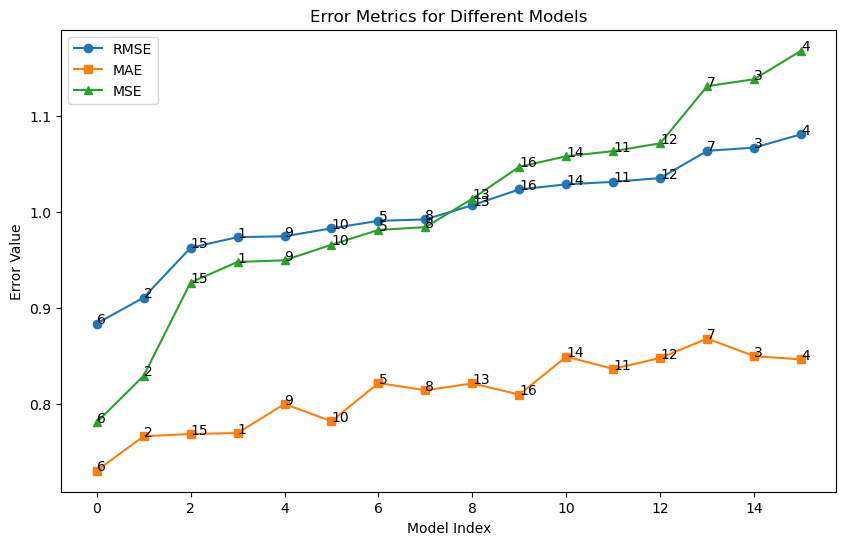

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

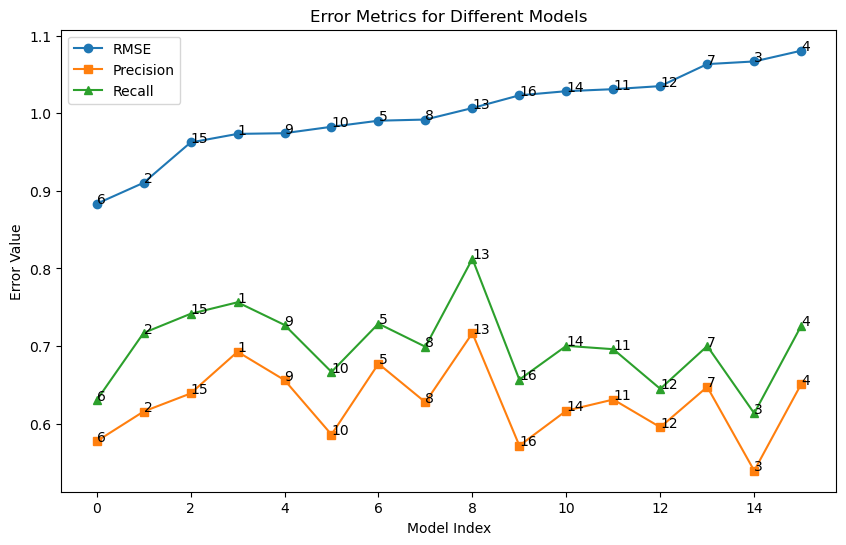

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

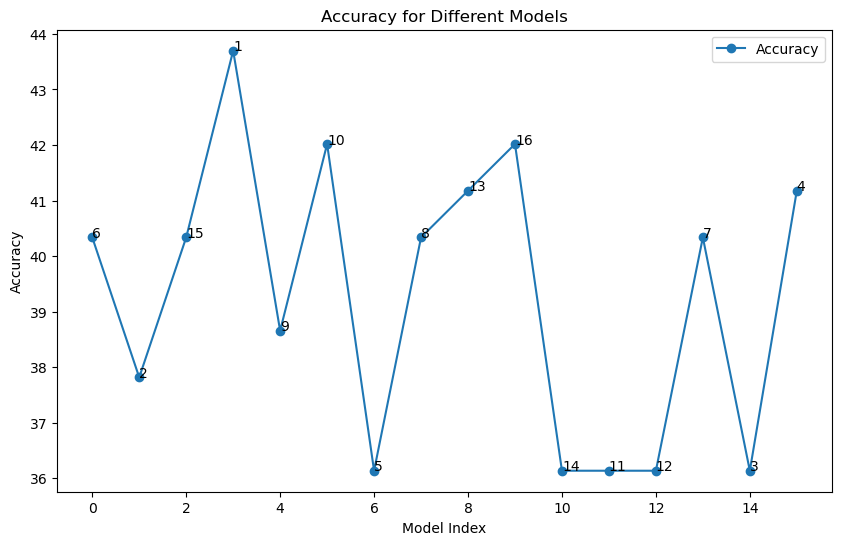

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_means.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Grand Saumur
2. Item ID: Fleurie Grand Pre
3. Item ID: Chateau Bouscasse
4. Item ID: Valle de Casablanca Sauvignon
5. Item ID: Cirus Madiran


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_means.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_means.get_neighbors_uid(user_id=5)

['1b02b02d-e152-4b2e-a276-56fcc4069250',
 '47edd867-4e96-411a-b436-970e5f750b03',
 '76b71bb0-6cc9-4168-8a45-bbafc1e9a256',
 '13016d41-00bd-411c-83f5-2b95691696b7',
 '3da6eec4-bd99-4370-be23-676baf750f19',
 'a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8',
 '70c67292-57ce-4012-a939-5e6ddcb499f8',
 'bec96c0b-5b0b-4992-8756-e0d3b704afb5',
 'defee34b-7775-4889-b703-92b730d85e70',
 'd229f371-d36c-4e52-8806-fdd41896c689']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_means.get_neighbors_iid(item_id=20)

['Napa Valley Fumé Blanc',
 "The Old Man's Blend",
 'Sauvignon Blanc',
 'Aspromonte',
 'I Saltari Valpolicella Superiore',
 'Alsace Josmeyer Gewurztraminer Biodynamic',
 'Chateauneuf-Du-Pape',
 'Puntalice',
 'Cabernet Sauvignon',
 'Sierra Foothills Zinfandel']

In [28]:
knn_with_means.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_means.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 18 with sim 0.000000000000000
And the baseline estimate is: 4.285097062890682

#####

Note: If the baseline is 3.679790026246719 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_means.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,70c67292-57ce-4012-a939-5e6ddcb499f8,Sauvignon Blanc,5.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",2,3,1.000000
1,9250d444-805f-4756-a03b-93a597ab320d,Alazani Valley Red Semi Sweet (ალაზნის ველი წი...,4.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",2,1,0.267717
2,c3371365-d499-4675-aa68-dbc7b11f0777,Picpoul de Pinet Higues de Beauvignac,5.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",0,0,1.267717
3,91cf68cc-9436-43e1-871d-33beef4d2337,Domaine Grand Veneur Blanc de Viogier,3.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,1,0.732283
4,bc8f3005-c2c6-4277-9fd7-340248f4e7ec,Natum Pecorino,4.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",6,0,0.267717
5,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Le Grand Saumur,3.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,1,0.732283
6,ff89d8c1-48a3-49b5-af95-62d0ce9ecf55,Grey (Glacier) Cabernet Sauvignon,5.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",2,1,1.267717
7,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Vieilles Vignes Rouge,5.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",18,1,1.267717
8,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Sharis,4.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",18,1,0.267717
9,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Terrano,2.0,2.888302,"{'actual_k': 2, 'was_impossible': False}",6,7,0.888302


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
77,b61f83a4-48c5-49a5-aee5-72f7d5221b2a,Sauvignon Blanc,4.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",3,3,0.000000
35,e786582d-0deb-4e55-969e-065508ca1138,Terrano,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",2,7,0.000000
74,25a04c51-5638-42f0-b2e7-ce49b1c280fc,Pigato Riviera Ligure di Ponente,4.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",5,2,0.000000
22,441ac739-42f8-48d2-9526-fdedf2d4852f,Terrano,2.0,2.000000,"{'actual_k': 1, 'was_impossible': False}",2,7,0.000000
111,cabb87a0-6498-438a-beb7-676f72bddd09,Sauvignon Blanc,4.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",1,3,0.000000
105,e786582d-0deb-4e55-969e-065508ca1138,Pinot Noir,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",2,3,0.000000
16,4a3e010a-0761-48d4-90c1-b2905e0b7b4a,Pinot Noir,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",5,3,0.000000
36,bc79b0e3-064d-4240-86de-e86499f577e8,3／Chevalier de Lascomes,4.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,1,0.267717
42,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Sangiovese Superiore,4.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",18,0,0.267717
91,2bb306b3-5e47-40b1-ab05-eee62cafb1b8,Lyric Pinot Noir,4.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.267717


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
53,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Fleurie Grand Pre,2.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,1,1.732283
54,91cf68cc-9436-43e1-871d-33beef4d2337,St. Hallett Barossa,2.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,1,1.732283
60,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,0,1.732283
80,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Cirus Madiran,2.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,0,1.732283
27,a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8,Fairbridge,2.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",11,1,1.732283
92,13016d41-00bd-411c-83f5-2b95691696b7,Terrano,2.0,4.000000,"{'actual_k': 1, 'was_impossible': False}",15,7,2.000000
59,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Pinot grigio,2.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",14,0,2.000000
95,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 11,1.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",13,1,2.732283
41,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.732283
46,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,3.732283,"{'was_impossible': True, 'reason': 'User and/o...",0,0,2.732283
